In [10]:
%matplotlib inline

In [11]:
import os
import gym
import math
import random
import numpy as np
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import pkg_resources
import time

import matplotlib.pyplot as plt


pkg_resources.get_distribution("gym").version






'0.26.2'

In [12]:
# import wandb

# wandb.init(project="frozen lake", entity="xdvisch")


In [13]:
from gym.wrappers.human_rendering import HumanRendering
from gym.envs.toy_text.frozen_lake import generate_random_map

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# env = gym.make('CartPole-v1',  render_mode='rgb_array').unwrapped
env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=False, render_mode="rgb_array")
wrapped = HumanRendering(env)
wrapped.reset()



resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
# This is based on the code from gym.
screen_width = 600
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 5000
TARGET_UPDATE = 10
device

C:\Users\xande\AppData\Local\Temp\ipykernel_17636\4184701082.py:13: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBIC),
c:\Users\xande\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


device(type='cuda')

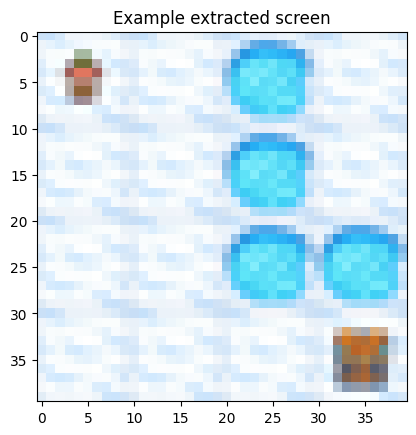

In [14]:
# def get_cart_location():
#     world_width = env.screen_width
#     scale = screen_width / world_width
#     return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render().transpose((2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    # screen = screen[:, 160:320]
    # view_width = 320
    # cart_location = get_cart_location()
    
    # if cart_location < view_width // 2:
    #     slice_range = slice(view_width)
    # elif cart_location > (screen_width - view_width // 2):
    #     slice_range = slice(-view_width, None)
    # else:
    #     slice_range = slice(cart_location - view_width // 2,
    #                         cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    # screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()


In [15]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [16]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()

    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)


    # wandb.log({"eps_threshold": eps_threshold})
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)




def optimize_model(policy_net, optimizer, memory):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = policy_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = ((next_state_values * GAMMA) + reward_batch).unsqueeze(1)

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    # wandb.log({"loss": loss})
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [17]:


# Define the custom x axis metric
# wandb.define_metric("episode")

# Define which metrics to plot against that x-axis
# wandb.define_metric("duration", step_metric='episode')

def trainIters(policy_net, n_iters=60):
    optimizer = optim.Adam(policy_net.parameters(), lr=0.0001, weight_decay=1e-5)
    memory = ReplayMemory(10000)
    for iter in range(n_iters):
        # Initialize the environment and state
        env.reset()
        wrapped.reset()
        
        # 2 beelden
        # last_screen = get_screen()
        # current_screen = get_screen()
        # state = current_screen - last_screen

        # 1 beelden
        state = get_screen()
        
        # print(f"shape beeld:{state.shape}")
        losses = []
        spel_gelukt = 0

        for t in count():
            env.render()
            wrapped._render_frame()

            action = select_action(state)
            _, reward, done, _, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # 2 beelden
            # last_screen = current_screen
            # current_screen = get_screen()

            if not done or ( t % 500 == 0):
                # 1 beeld
                next_state = get_screen()

                # 2 beelden
                # next_state = current_screen - last_screen
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)
            
            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            optimize_model(policy_net, optimizer, memory)
            if done:
                if reward:
                    spel_gelukt = 1
                
                # log_dict = {
                # "episode": iter + 1,
                
                # "rewarc achived": spel_gelukt
                # }
                # wandb.log(log_dict)
                # print('Iteration: {}, Score: {}'.format(iter + 1, t))
                env.desc = generate_random_map(size=4)
                
                break

    torch.save(policy_net, 'model/policy_net_frozen_lake.pkl')
    # print('Complete')
    wrapped.render()
    wrapped.close()

    env.render()
    env.close()


In [18]:
if __name__ == "__main__":
    if os.path.exists('model/policy_net_frozen_lake.pkl'):
        policy_net = torch.load('model/policy_net_frozen_lake.pkl')
        print('Model loaded')
        
    else:
        # Get screen size so that we can initialize layers correctly based on shape
        # returned from AI gym. Typical dimensions at this point are close to 3x40x90
        # which is the result of a clamped and down-scaled render buffer in get_screen()
        init_screen = get_screen()
        _, _, screen_height, screen_width = init_screen.shape

        # Get number of actions from gym action space
        n_actions = env.action_space.n

        policy_net = DQN(screen_height, screen_width, n_actions).to(device)
    trainIters(policy_net, n_iters=50)

Model loaded


C:\Users\xande\AppData\Local\Temp\ipykernel_17636\3094724977.py:44: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:28.)
  next_state_values[non_final_mask] = policy_net(non_final_next_states).max(1)[0].detach()
